In [1]:
from __future__ import print_function
from fenics import *
from ufl import nabla_div
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
import petsc4py
petsc4py.init()
from petsc4py import PETSc
import time
import CartFuncs as CF
%matplotlib inline


# PETSc Tutorial 

https://computationalmechanics.in/vector-and-matrix-operations-in-petsc-via-petsc4py/

In [ ]:
n = 10 # Size of vector
x = PETSc.Vec().createSeq(n) # Faster way to create a sequential vector.
x.setValues(range(n), range(n))
print(x.getArray())
print(x.getValues(3))
print(x.getValues([1, 2]))

In [ ]:
#add scalar to a vector
x.setValues(range(n), range(n))
x.shift(1)
print(x.getArray())
x.shift(-1)
print(x.getArray())

In [ ]:
#adding 2 vectors
x.setValues(range(n), range(n))
y = PETSc.Vec().createSeq(n)
y.setValues(range(n), range(n))
z=x+y
print(z.getArray())

In [ ]:
#sum entries of vector
print(x.sum())
print(x.min())
print(x.max())

In [ ]:
#vector dot product
print(x.dot(x)) # dot product with self
print(x.dot(y)) # dot product with another vector

In [ ]:
print ('2-norm =', x.norm())
print ('Infinity-norm =', x.norm(PETSc.NormType.NORM_INFINITY))

In [ ]:
m, n = 4, 4 # size of the matrix
A = PETSc.Mat().createAIJ([m, n]) # AIJ represents sparse matrix
A.setUp()
A.assemble()

In [ ]:
#use getValues method to print
print(A.getValues(range(m), range(n)))
print(A.getValues(range(2), range(1)))

In [ ]:
#setting values to matrix
#setValue(self, row, col, value, addv=None) will assign the value to the mentioned [row][col] index of the matrix 
#and setValues(self, rows, cols, values, addv=None) will assign values to the positions obtained from the tensor product of rows and cols.
A.setValue(1, 1, -9)
A.setValue(0, 0, -2)
A.setValue(2, 2, -5)
A.setValue(3, 3, 6)
#looks like row major
A.setValues([0, 1], [2, 3], [1, 2, 4, 8])
A.assemble()
print(A.getValues(range(m), range(n)))

In [ ]:
#get size and transpose
print(A.getSize())
B = A.copy()
B.transpose()
print(A.getSize(), B.getSize())
print(B.getValues(range(4), range(4)))


In [ ]:
#matrix multiplication
C = A.matMult(B)
print(C.getValues(range(m), range(n)))

In [ ]:
#mult(self, Vec x, Vec y) multiply matrix with vector x where y is the resulting vector
x = PETSc.Vec().createSeq(4) # making the x vector
x.set(1) # assigning value 1 to all the elements
y = PETSc.Vec().createSeq(4) # Put answer here.
A.mult(x, y) # A*x = y
print(y.getArray())

In [ ]:
#most simple solver is krylov
print("Matrix A: ")
print(A.getValues(range(m), range(n))) # printing the matrix A defined above

b = PETSc.Vec().createSeq(4) # creating a vector
b.setValues(range(4), [10, 5, 3, 6]) # assigning values to the vector

print('\\n Vector b: ')
print(b.getArray()) # printing the vector 

x = PETSc.Vec().createSeq(4) # create the solution vector x

ksp = PETSc.KSP().create() # creating a KSP object named ksp
ksp.setOperators(A)

# Allow for solver choice to be set from command line with -ksp_type <solver>.
ksp.setFromOptions()
print ('\\n Solving with:', ksp.getType()) # prints the type of solver

# Solve!
ksp.solve(b, x) 

print('\\n Solution vector x: ')
print(x.getArray())

In [ ]:
#now using PETSc interface to FEniCS
nx = 10
mesh = UnitIntervalMesh(nx)
V=FunctionSpace(mesh,'P',1)
u = TrialFunction(V)
v = TestFunction(V)

k_form = u*v*dx
f_form = v*dx

K = PETScMatrix()

assemble(k_form, tensor=K)
print(type(K))
#change to petsc objet
Kp = as_backend_type(K).mat()
print(type(Kp))


#how to assemble vector?
F = PETScVector()
assemble(f_form, tensor=F)
print(type(F))

Fp = as_backend_type(F).vec()
print(type(Fp))


In [ ]:
#other case, if I have a numpy matrix X
X = np.array([[1,2,3],[4,5,6]])
print(X.shape)
print(X)
Xp = PETSc.Mat().createAIJ(X.shape)
Xp.setUp()
Xp.setValues(range(0, X.shape[0]), range(0, X.shape[1]), X) # copy X matrix into petsc matrix
Xp.assemble()
print(Xp.getValues(range(0, X.shape[0]), range(0, X.shape[1])))


In [ ]:
print(X.shape[1])

In [ ]:
#try np kron of 2 fenics matrices
nx = 4
mesh = UnitIntervalMesh(nx)
V=FunctionSpace(mesh,'P',1)
u = TrialFunction(V)
v = TestFunction(V)

k_form = u*v*dx
f_form = v*dx

K = PETScMatrix()

assemble(k_form, tensor=K)
print(type(K))
#change to petsc objet
Kp = K.mat()
print(type(Kp))


#how to assemble vector?
F = PETScVector()
assemble(f_form, tensor=F)
print(type(F))

Fp = F.vec()
print(type(F))

#do petsc kron, looks like it has to be manual

Big_K = CF.kron_PETSC(Kp,Kp)
Big_K.setValues(1,range(nx+1),np.ones(nx+1))
Big_K.assemble()

print(Kp.getValues(range(nx+1),range(nx+1)))
print(Big_K.getValues(range(nx+1),range(nx+1)))
print(Big_K.getSize())


# Let's try a steady state example and compare timing

In [2]:
t0 = time.time()
#first create mesh, mesh 1 is space, mesh 2 is sigma
x_min = -0.5
x_max = 0.5
y_min = -0.5
y_max = 0.5
nx = 25
ny = 25


mesh1 = IntervalMesh(nx,x_min,x_max)
mesh2 = IntervalMesh(ny,y_min,y_max)

V1 = FunctionSpace(mesh1, 'P', 1)
V2 = FunctionSpace(mesh2, 'P', 1)
dof_coordinates1=V1.tabulate_dof_coordinates()
dof_coordinates2=V2.tabulate_dof_coordinates()

#create trial and test functions
u1_trial = TrialFunction(V1)
v1_test = TestFunction(V1)
u2_trial = TrialFunction(V2)
v2_test = TestFunction(V2)
#generate weak forms
n1=FacetNormal(mesh1)
n2=FacetNormal(mesh2)



K11 = u1_trial*v1_test*dx
K12 = u1_trial*v1_test.dx(0)*dx
K14 = dot(n1,as_vector((u1_trial,)))*v1_test*ds
K21 = u2_trial*v2_test*dx
K22 = u2_trial*v2_test.dx(0)*dx
K24 = dot(n2,as_vector((u2_trial,)))*v2_test*ds

K11 = assemble(K11)
K12 = assemble(K12)
K14 = assemble(K14)
K21 = assemble(K21) 
K22 = assemble(K22)
K24 = assemble(K24)



#use this to mark boundary (Dirichlet) 
def boundary(x, on_boundary):
    return on_boundary and (near(x[0],x_min, 1e-14))

#This function is simply used to mark the boundary (not the actual boundary condition)
u_D1 = Expression('1.0', degree=2)


#establish dummy functions
dum1=Function(V1)
dum2=Function(V2)


#create boundary conditions
#in this case, only dirichlet for one side of x and none for sigma
#still need to mark boundaries tho ???,
#there is probably a more efficient way to do this
bc1 = DirichletBC(V1, u_D1, boundary)
bc2 = DirichletBC(V2, u_D1, boundary)

#apply to vectors to mark boundaries
bc1.apply(dum1.vector())
bc2.apply(dum2.vector())
#get index number for each boundary cooordinates in subdomain
boundary_dofs1 = np.where(dum1.vector()==1.0)[0]
boundary_dofs2 = np.where(dum2.vector()==1.0)[0]
#need all physical coordinates in case we need for calculations


#physical coordinates should be just cartesian product of 2 dof maps in same order that kron product operates
global_dof=CF.cartesian_product_coords(dof_coordinates1,dof_coordinates2)
#split into x,y
x = global_dof[:,0]
y = global_dof[:,1]
N_dof = len(x)

#coordinates of boundary in each subdomain
boundary_coord1 = dof_coordinates1[boundary_dofs1]
boundary_coord2 = dof_coordinates2[boundary_dofs2]
#now connect subdomain indeces to global boundary (turn this into function in future)
#maybe in future for speed we can precompute number of boundary dofs
#global_boundary_dofs=np.empty((len(boundary_dofs1)*len(dof_coordinates2),2))
global_boundary_dofs=np.empty((len(boundary_dofs1)*len(dof_coordinates2) + len(dof_coordinates1)*len(boundary_dofs2),2))

ctr=0
for j in boundary_dofs1:
    global_boundary_dofs[ctr*len(dof_coordinates2):(ctr+1)*len(dof_coordinates2),:] = \
    CF.cartesian_product_dofs(np.array([j]),np.arange(dof_coordinates2.shape[0]))
    ctr=ctr+1

last_ind = (ctr)*len(dof_coordinates2)


for j in boundary_dofs2:
    global_boundary_dofs[last_ind:last_ind+len(dof_coordinates1),:] = \
    CF.cartesian_product_dofs(np.arange(dof_coordinates1.shape[0]),np.array([j]))
    last_ind = last_ind+len(dof_coordinates1)    
    
#sorts and also eliminates duplicates of "corners"
global_boundary_dofs=np.unique(global_boundary_dofs,axis=0)

#have cartesian product of dof at entire boundary (this form should be easy to get coordinates in if needed)
#now need to convert to global system dof as the kron function does
global_boundary_dofs=CF.cartesian_form_to_kroneck_form(global_boundary_dofs, len(dof_coordinates2))
global_boundary_dofs=global_boundary_dofs.astype(int)

#print(x[global_boundary_dofs])
#print(y[global_boundary_dofs])

#now manually for now select only left and bottom sides of rectangle
#this is redundant
dum1 = global_boundary_dofs[x[global_boundary_dofs]<=(x_min+1e-14)]
dum2 = global_boundary_dofs[y[global_boundary_dofs]<=(y_min+1e-14)]
global_boundary_dofs = np.unique(np.concatenate((dum1,dum2),0))

#print(x[global_boundary_dofs])
#print(y[global_boundary_dofs])



#define velocities
cx = np.ones(x.shape)
cy = np.ones(y.shape)



u = CF.u_pointwise(x,y)

S = CF.S_pointwise(x,y)

#establish global stiffness matrix
K11 = np.array(K11.array())
K12 = np.array(K12.array())
K14 = np.array(K14.array())
K21 = np.array(K21.array())
K22 = np.array(K22.array())
K24 = np.array(K24.array())

A = np.kron(K11,K21)-np.kron(K12,K21)-np.kron(K11,K22) + \
    +np.kron(K14,K21) + \
    + np.kron(K11,K24)


#Try trick from hughes
F = np.kron(np.array(K11),np.array(K21))

###for case 2 lets try a modified version instead of what we have been doing
#RHS is (np.sin(x)*np.sin(y) + np.cos(x)*np.sin(y) + np.sin(x)*np.cos(y))*vdx
#F = np.kron(np.array(F11),np.array(F21)) + np.kron(np.array(F12),np.array(F21)) + np.kron(np.array(F11),np.array(F22))


#wipe out rows of global matrix that need to be dirichlet
K_bound = np.zeros(A.shape)
for i in global_boundary_dofs:
    K_bound[i,i] = 1

A[global_boundary_dofs,:] = K_bound[global_boundary_dofs,:]




#now solve system

RHS = F.dot(S)
#RHS = F_old*S
RHS[global_boundary_dofs] = u[global_boundary_dofs]

t_s = time.time()
#try petsc
#'''
A_pet = PETSc.Mat().createAIJ(A.shape)
A_pet.setUp()
A_pet.setValues(range(0, A.shape[0]), range(0, A.shape[1]), A) # copy X matrix into petsc matrix
A_pet.assemble()

RHS_pet = PETSc.Vec().createSeq(N_dof)
#RHS_pet.setUp()
RHS_pet.setValues(range(0, RHS.shape[0]), RHS) # copy X matrix into petsc matrix
#RHS_pet.assemble()

#make krylov solver
ksp = PETSc.KSP().create() # creating a KSP object named ksp
ksp.setOperators(A_pet)
ksp.setFromOptions()

#set up solution vector
u_cart = PETSc.Vec().createSeq(N_dof)
#'''
#end of petsc
t_e = time.time()
#for cas 2 just try F
#RHS = F
t1=time.time()
ksp.solve(RHS_pet, u_cart)
#u_cart=np.linalg.solve(A,RHS)
t2=time.time()


In [3]:
u_cart = u_cart.getArray()
print('Cartesian Errors')
print('l inf error')
print(max(abs(u-u_cart)))
print('RMSE error')
print(np.sqrt(1/len(u_cart)*np.dot(np.absolute(u_cart - u),np.absolute(u_cart-u))))
print('dof = ',len(u_cart))

print('Assembly time:')
print(t1-t0)
print('Petsc time')
print(t_e-t_s)
print('Solve time')
print(t2-t1)
print('Total time')
print(t2-t0)

Cartesian Errors
l inf error
0.000249625783354
RMSE error
0.000113993946605
dof =  676
Assembly time:
17.964052438735962
Petsc time
17.771190404891968
Solve time
1.0251119136810303
Total time
18.989164352416992


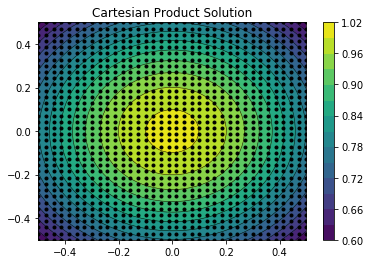

In [6]:
fig,  ax2 = plt.subplots(nrows=1)

ax2.tricontour(global_dof[:,0], global_dof[:,1], u_cart, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(global_dof[:,0], global_dof[:,1], u_cart, levels=14)#, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(global_dof[:,0], global_dof[:,1], 'ko', ms=3)
#ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_title('Cartesian Product Solution')

plt.subplots_adjust(hspace=0.5)
plt.show()

# Try now if assembly procedure with PETSc gives speedup

In [2]:
t0 = time.time()
#first create mesh, mesh 1 is space, mesh 2 is sigma
x_min = -0.5
x_max = 0.5
y_min = -0.5
y_max = 0.5
nx = 25
ny = 25


mesh1 = IntervalMesh(nx,x_min,x_max)
mesh2 = IntervalMesh(ny,y_min,y_max)

V1 = FunctionSpace(mesh1, 'P', 1)
V2 = FunctionSpace(mesh2, 'P', 1)
dof_coordinates1=V1.tabulate_dof_coordinates()
dof_coordinates2=V2.tabulate_dof_coordinates()

#create trial and test functions
u1_trial = TrialFunction(V1)
v1_test = TestFunction(V1)
u2_trial = TrialFunction(V2)
v2_test = TestFunction(V2)
#generate weak forms
n1=FacetNormal(mesh1)
n2=FacetNormal(mesh2)


K11_pet = PETScMatrix()
K12_pet = PETScMatrix()
K14_pet = PETScMatrix()
K21_pet = PETScMatrix()
K22_pet = PETScMatrix()
K24_pet = PETScMatrix()

K11 = u1_trial*v1_test*dx
K12 = u1_trial*v1_test.dx(0)*dx
K14 = dot(n1,as_vector((u1_trial,)))*v1_test*ds
K21 = u2_trial*v2_test*dx
K22 = u2_trial*v2_test.dx(0)*dx
K24 = dot(n2,as_vector((u2_trial,)))*v2_test*ds





assemble(K11,tensor = K11_pet)
assemble(K12,tensor = K12_pet)
assemble(K14,tensor = K14_pet)
assemble(K21, tensor = K21_pet) 
assemble(K22, tensor = K22_pet)
assemble(K24, tensor = K24_pet)


K11_pet = K11_pet.mat()
K12_pet = K12_pet.mat()
K14_pet = K14_pet.mat()
K21_pet = K21_pet.mat()
K22_pet = K22_pet.mat()
K24_pet = K24_pet.mat()


#use this to mark boundary (Dirichlet) 
def boundary(x, on_boundary):
    return on_boundary and (near(x[0],x_min, 1e-14))

#This function is simply used to mark the boundary (not the actual boundary condition)
u_D1 = Expression('1.0', degree=2)


#establish dummy functions
dum1=Function(V1)
dum2=Function(V2)


#create boundary conditions
#in this case, only dirichlet for one side of x and none for sigma
#still need to mark boundaries tho ???,
#there is probably a more efficient way to do this
bc1 = DirichletBC(V1, u_D1, boundary)
bc2 = DirichletBC(V2, u_D1, boundary)

#apply to vectors to mark boundaries
bc1.apply(dum1.vector())
bc2.apply(dum2.vector())
#get index number for each boundary cooordinates in subdomain
boundary_dofs1 = np.where(dum1.vector()==1.0)[0]
boundary_dofs2 = np.where(dum2.vector()==1.0)[0]
#need all physical coordinates in case we need for calculations


#physical coordinates should be just cartesian product of 2 dof maps in same order that kron product operates
global_dof=CF.cartesian_product_coords(dof_coordinates1,dof_coordinates2)
#split into x,y
x = global_dof[:,0]
y = global_dof[:,1]
N_dof = len(x)

#coordinates of boundary in each subdomain
boundary_coord1 = dof_coordinates1[boundary_dofs1]
boundary_coord2 = dof_coordinates2[boundary_dofs2]
#now connect subdomain indeces to global boundary (turn this into function in future)
#maybe in future for speed we can precompute number of boundary dofs
#global_boundary_dofs=np.empty((len(boundary_dofs1)*len(dof_coordinates2),2))
global_boundary_dofs=np.empty((len(boundary_dofs1)*len(dof_coordinates2) + len(dof_coordinates1)*len(boundary_dofs2),2))

ctr=0
for j in boundary_dofs1:
    global_boundary_dofs[ctr*len(dof_coordinates2):(ctr+1)*len(dof_coordinates2),:] = \
    CF.cartesian_product_dofs(np.array([j]),np.arange(dof_coordinates2.shape[0]))
    ctr=ctr+1

last_ind = (ctr)*len(dof_coordinates2)


for j in boundary_dofs2:
    global_boundary_dofs[last_ind:last_ind+len(dof_coordinates1),:] = \
    CF.cartesian_product_dofs(np.arange(dof_coordinates1.shape[0]),np.array([j]))
    last_ind = last_ind+len(dof_coordinates1)    
    
#sorts and also eliminates duplicates of "corners"
global_boundary_dofs=np.unique(global_boundary_dofs,axis=0)

#have cartesian product of dof at entire boundary (this form should be easy to get coordinates in if needed)
#now need to convert to global system dof as the kron function does
global_boundary_dofs=CF.cartesian_form_to_kroneck_form(global_boundary_dofs, len(dof_coordinates2))
global_boundary_dofs=global_boundary_dofs.astype(int)

#print(x[global_boundary_dofs])
#print(y[global_boundary_dofs])

#now manually for now select only left and bottom sides of rectangle
#this is redundant
dum1 = global_boundary_dofs[x[global_boundary_dofs]<=(x_min+1e-14)]
dum2 = global_boundary_dofs[y[global_boundary_dofs]<=(y_min+1e-14)]
global_boundary_dofs = np.unique(np.concatenate((dum1,dum2),0))

#print(x[global_boundary_dofs])
#print(y[global_boundary_dofs])



#define velocities
cx = np.ones(x.shape)
cy = np.ones(y.shape)



u = CF.u_pointwise(x,y)

S = CF.S_pointwise(x,y)

#establish global stiffness matrix
A = CF.Mass_assemble_PETSC(K11_pet,K12_pet,K14_pet,K21_pet,K22_pet,K24_pet)
#A = CF.kron_PETSC(K11_pet,K21_pet) - CF.kron_PETSC(K12_pet,K21_pet) - CF.kron_PETSC(K11_pet,K22_pet) +\
#    CF.kron_PETSC(K14_pet,K21_pet) + CF.kron_PETSC(K11_pet,K24_pet)


#A = np.kron(K11,K21)-np.kron(K12,K21)-np.kron(K11,K22) + \
#    +np.kron(K14,K21) + \
#    + np.kron(K11,K24)


#Try trick from hughes
F = CF.kron_PETSC(K11_pet,K21_pet)
F.assemble()
#F = np.kron(np.array(K11),np.array(K21))

###for case 2 lets try a modified version instead of what we have been doing
#RHS is (np.sin(x)*np.sin(y) + np.cos(x)*np.sin(y) + np.sin(x)*np.cos(y))*vdx
#F = np.kron(np.array(F11),np.array(F21)) + np.kron(np.array(F12),np.array(F21)) + np.kron(np.array(F11),np.array(F22))
RHS_pet = PETSc.Vec().createSeq(N_dof) # Faster way to create a sequential vector.
#set RHS
S_pet = PETSc.Vec().createSeq(N_dof)
S_pet.setValues(range(N_dof), S)

F.mult(S_pet,RHS_pet)
#wipe out rows of global matrix that need to be dirichlet
K_bound = np.eye(N_dof)
for i in global_boundary_dofs:
    A.setValues(i,range(N_dof),K_bound[i,:])
    RHS_pet.setValues(i, u[i])

A.assemble()


#make krylov solver
ksp = PETSc.KSP().create() # creating a KSP object named ksp
ksp.setOperators(A)
ksp.setFromOptions()

#set up solution vector
u_cart = PETSc.Vec().createSeq(N_dof)

#end of petsc
t_s = time.time()
t_e = time.time()
#for cas 2 just try F
#RHS = F
t1=time.time()
ksp.solve(RHS_pet, u_cart)
#u_cart=np.linalg.solve(A,RHS)
t2=time.time()


In [3]:
u_cart = u_cart.getArray()
print('Cartesian Errors')
print('l inf error')
print(max(abs(u-u_cart)))
print('RMSE error')
print(np.sqrt(1/len(u_cart)*np.dot(np.absolute(u_cart - u),np.absolute(u_cart-u))))
print('dof = ',len(u_cart))

print('Assembly time:')
print(t1-t0)
print('Petsc time')
print(t_e-t_s)
print('Solve time')
print(t2-t1)
print('Total time')
print(t2-t0)

Cartesian Errors
l inf error
0.000249625783352
RMSE error
0.000113993946605
dof =  676
Assembly time:
37.764643907547
Petsc time
0.00012540817260742188
Solve time
0.13306713104248047
Total time
37.89771103858948


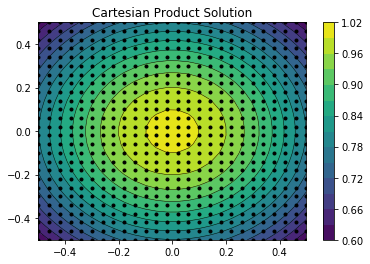

In [4]:
fig,  ax2 = plt.subplots(nrows=1)

ax2.tricontour(global_dof[:,0], global_dof[:,1], u_cart, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(global_dof[:,0], global_dof[:,1], u_cart, levels=14)#, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(global_dof[:,0], global_dof[:,1], 'ko', ms=3)
#ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_title('Cartesian Product Solution')

plt.subplots_adjust(hspace=0.5)
plt.show()